In [1]:
import os
import requests
import json
import itertools

import math
import pandas as pd
import urllib.request

In [2]:
#Every request begins with the server's URL
SERVER = 'http://data.neonscience.org/api/v0/'

In [3]:
site_codes = [
    'UNDE',
    'WOOD',
    'CPER',
    'NIWO',
    'KONZ',
    'HARV',
    'SCBI',
    'OSBS',
    'TALL',
    'CLBJ',
    'SRER',
    'ONAQ',
    'SJER',
    'WREF',
    'YELL',
    'GUAN',
    'BONA',
    'TOOL',
    'PUUM',
    'ORNL'
]

In [4]:
import os.path

def get_family_data_from_site(SITE_CODE):
    # plant presence and percent cover
    PRODUCTCODE = 'DP1.10058.001'
    
    url = SERVER+'sites/'+SITE_CODE
    
    #Request the url
    site_request = requests.get(url)

    #Convert the request to Python JSON object
    site_json = site_request.json()
    
    months = []

    for product in site_json['data']['dataProducts']: 
        #if a list item's 'dataProductCode' dict element equals the product code string
        if(product['dataProductCode'] == PRODUCTCODE): 
            for month in product['availableMonths']:
                months.append(month)

    months.sort()
    
    print(SITE_CODE, months)
    
    month_idx = 0
    latest_month = months[0]
    df = None
    
    # try an earlier month
    def redownload_data():    
        nonlocal df
        nonlocal month_idx
        nonlocal latest_month
        
        month_idx -= 1
        
        if month_idx < -len(months):
            df = None
            return
        
        latest_month = months[month_idx]
        latest_month = months[month_idx]
        data_request = requests.get(SERVER+'data/'+PRODUCTCODE+'/'+SITE_CODE+'/'+latest_month)
        data_json = data_request.json()

        url = None
        name = None

        for file in data_json['data']['files']:
            if '1m2' in file['name']:
                url = file['url']
                name = file['name']

        if not os.path.isfile('data/' + name):
            urllib.request.urlretrieve(url, 'data/' + name)

        df = pd.read_csv('data/' + name)
    
    redownload_data()
    
    # redownload earlier data if more than half of family/percentcover data is Nan
    while True:
        if df is None:
            return (None, None)
        
        num_rows = df.shape[0]
        num_nan = max(df['family'].isnull().sum(), df['percentCover'].isnull().sum())

        print('nan', num_nan, 'rows', num_rows)
        
        if num_nan > num_rows - 50:
            # try an earlier month
            redownload_data()
        else:
            break
    
    avg_tracker = dict()

    def isnan(val):
        return type(val) == float and math.isnan(val)

    for index, row in df.iterrows():
        if isnan(row['family']) or isnan(row['percentCover']):
            continue

        family = row['family']
        percCover = row['percentCover']

        if family not in avg_tracker:
            avg_tracker[family] = (0, 0)

        avg_tracker[family] = (avg_tracker[family][0] + percCover, avg_tracker[family][1] + 1)

    avgPercCover = []
    sumAvgPercCover = 0

    for key in avg_tracker:
        avgPercCover.append((key, avg_tracker[key][0] / avg_tracker[key][1]))
        sumAvgPercCover += avgPercCover[-1][1]

    return (latest_month, avgPercCover)

In [5]:
class DictTable(dict):
    # Overridden dict class which takes a dict in the form {'a': 2, 'b': 3},
    # and renders an HTML Table in IPython Notebook.
    def _repr_html_(self):
        html = ["<table width=100%>"]
        for key, value in iter(self.items()):
            html.append("<tr>")
            html.append("<td>{0}</td>".format(key))
            html.append("<td>{0}</td>".format(value))
            html.append("</tr>")
        html.append("</table>")
        return ''.join(html)

In [6]:
data = []

for site in site_codes:
    month, percCover = get_family_data_from_site(site)
    
    data.append((month, percCover))

UNDE ['2014-06', '2014-07', '2015-06', '2015-07', '2016-06', '2016-07', '2016-08', '2017-05', '2017-06', '2017-07', '2018-06', '2018-07', '2019-06', '2019-07', '2020-06', '2020-07', '2020-10', '2021-06', '2021-07', '2022-06', '2022-07', '2022-08']
nan 108 rows 108
nan 185 rows 505
WOOD ['2014-06', '2014-07', '2014-08', '2015-08', '2016-08', '2016-09', '2017-08', '2018-08', '2019-08', '2020-08', '2021-07', '2021-08', '2022-07', '2022-08', '2022-09']
nan 2 rows 2
nan 269 rows 835
CPER ['2013-06', '2013-07', '2013-08', '2013-09', '2013-10', '2014-05', '2014-06', '2014-07', '2014-08', '2014-09', '2015-06', '2015-07', '2015-09', '2016-05', '2016-06', '2016-08', '2017-05', '2017-06', '2018-05', '2018-06', '2019-05', '2019-06', '2020-06', '2021-05', '2022-05', '2022-06']
nan 362 rows 794
NIWO ['2015-07', '2015-08', '2016-07', '2016-08', '2017-07', '2017-08', '2017-09', '2018-06', '2018-07', '2018-08', '2019-07', '2019-08', '2020-07', '2020-08', '2021-06', '2021-07', '2021-08', '2022-07', '202

In [7]:
idx = 0
for site in site_codes:
    month, percCover = data[idx]
    
    if month is None:
        print('--', site, 'had no data', '---')
        continue
    
    print('---', site, month, '---')
    display(DictTable(percCover))
    
    idx += 1

--- UNDE 2022-07 ---


Caprifoliaceae,4.428571428571429
Rosaceae,1.28125
Liliaceae,1.7647058823529411
Pyrolaceae,1.1666666666666667
Ranunculaceae,4.75
Oleaceae,1.6875
Grossulariaceae,8.0
Primulaceae,1.5
Betulaceae,31.333333333333332
Pinaceae,3.625
Onagraceae,0.6111111111111112


--- WOOD 2022-08 ---


Asclepiadaceae,1.46
Polygonaceae,4.888888888888889
Poaceae,11.626288659793815
Asteraceae,4.436567164179104
Fabaceae,5.3428571428571425
Rosaceae,3.026315789473684
Ranunculaceae,0.8076923076923077
Convolvulaceae,1.25
Cyperaceae,5.055555555555555
Campanulaceae,0.5
Rubiaceae,0.875


--- CPER 2022-06 ---


Chenopodiaceae,1.5865384615384615
Poaceae,6.608974358974359
Asteraceae,1.5892857142857142
Malvaceae,0.8589743589743589
Convolvulaceae,0.5
Polygonaceae,1.75
Cyperaceae,1.375
Boraginaceae,0.9166666666666666
Cactaceae,8.977272727272727
Fabaceae,0.5909090909090909
Brassicaceae,0.5


--- NIWO 2022-08 ---


Cyperaceae,2.0757575757575757
Poaceae,2.6739130434782608
Caryophyllaceae,1.7045454545454546
Salicaceae,7.25
Saxifragaceae,0.5
Fabaceae,0.5
Polemoniaceae,0.6
Rosaceae,4.379310344827586
Liliaceae,0.5
Polygonaceae,0.75
Juncaceae,6.2


--- KONZ 2022-09 ---


Poaceae,5.942168674698795
Asteraceae,2.2572815533980584
Santalaceae,2.5
Solanaceae,0.5625
Fabaceae,2.069105691056911
Cuscutaceae,0.75
Rhamnaceae,3.04
Lamiaceae,1.1935483870967742
Asclepiadaceae,0.5166666666666667
Euphorbiaceae,0.5895522388059702
Verbenaceae,0.75


--- HARV 2022-07 ---


Liliaceae,2.5234375
Fagaceae,4.524390243902439
Rosaceae,3.4069767441860463
Ericaceae,4.697802197802198
Pinaceae,3.533333333333333
Aceraceae,2.289473684210526
Betulaceae,4.2894736842105265
Rubiaceae,6.583333333333333
Dennstaedtiaceae,15.71875
Primulaceae,1.287037037037037
Berberidaceae,14.0


--- SCBI 2022-08 ---


Poaceae,11.939024390243903
Asclepiadaceae,1.4285714285714286
Rubiaceae,1.75
Vitaceae,1.0833333333333333
Anacardiaceae,3.1666666666666665
Violaceae,1.4166666666666667
Asteraceae,13.375
Caprifoliaceae,4.125
Brassicaceae,1.25
Apocynaceae,0.6666666666666666
Rosaceae,1.2


--- OSBS 2022-10 ---


Annonaceae,1.8
Fabaceae,0.9666666666666667
Asteraceae,1.0217391304347827
Poaceae,2.8189655172413794
Chrysobalanaceae,8.4
Cyperaceae,0.6923076923076923
Asclepiadaceae,0.5
Convolvulaceae,4.666666666666667
Fagaceae,8.0
Ericaceae,6.0
Polygonaceae,1.125


--- TALL 2022-09 ---


Smilacaceae,1.6642857142857144
Cyperaceae,1.5609756097560976
Loganiaceae,3.0476190476190474
Aceraceae,2.6363636363636362
Ericaceae,6.702898550724638
Fagaceae,4.613924050632911
Liliaceae,3.25
Pinaceae,5.782608695652174
Poaceae,6.509478672985782
Lamiaceae,0.8611111111111112
Vitaceae,9.2


--- CLBJ 2022-06 ---


Asteraceae,1.2439024390243902
Poaceae,4.7073170731707314
Fabaceae,2.9166666666666665
Anacardiaceae,12.1875
Linaceae,0.5
Cistaceae,0.7857142857142857
Euphorbiaceae,0.5714285714285714
Cyperaceae,4.0
Geraniaceae,0.5
Gentianaceae,0.5
Rubiaceae,1.6333333333333333


--- SRER 2022-08 ---


Nyctaginaceae,1.8078947368421052
Zygophyllaceae,4.362068965517241
Poaceae,3.860576923076923
Amaranthaceae,1.9185185185185185
Portulacaceae,0.7846715328467153
Acanthaceae,1.28125
Fabaceae,9.39655172413793
Euphorbiaceae,0.9937106918238994
Malvaceae,1.4840425531914894
Convolvulaceae,1.9672131147540983
Asteraceae,2.9851851851851854


--- ONAQ 2022-07 ---


Brassicaceae,0.6379310344827587
Asteraceae,2.9565217391304346
Poaceae,1.2658227848101267
Ranunculaceae,0.8103448275862069
Polygonaceae,0.5
Polemoniaceae,1.0625
Chenopodiaceae,4.2
Cupressaceae,17.0
Rosaceae,5.333333333333333
Geraniaceae,1.5
Boraginaceae,0.5


--- SJER 2021-04 ---


Polygonaceae,2.5294117647058822
Asteraceae,5.578431372549019
Geraniaceae,8.072727272727272
Poaceae,8.385542168674698
Crassulaceae,0.7
Boraginaceae,5.853658536585366
Onagraceae,1.2666666666666666
Rubiaceae,0.875
Fabaceae,2.5520833333333335
Liliaceae,2.142857142857143
Portulacaceae,1.9761904761904763


--- WREF 2022-08 ---


Dennstaedtiaceae,9.5
Liliaceae,3.35
Berberidaceae,11.16
Caprifoliaceae,3.66
Dryopteridaceae,6.0
Ericaceae,15.108333333333333
Rosaceae,6.625
Violaceae,1.9090909090909092
Pinaceae,13.217391304347826
Ranunculaceae,0.75
Primulaceae,0.7


--- YELL 2021-07 ---


Scrophulariaceae,0.5
Asteraceae,2.559479553903346
Geraniaceae,1.6666666666666667
Crassulaceae,0.5
Polygonaceae,1.5333333333333334
Polemoniaceae,0.6973684210526315
Poaceae,0.801762114537445
Rosaceae,2.3444444444444446
Santalaceae,1.0
Onagraceae,2.8421052631578947
Caprifoliaceae,2.5416666666666665


--- GUAN 2022-10 ---


Bignoniaceae,1.375
Myrtaceae,7.571428571428571
Bromeliaceae,2.0
Acanthaceae,3.0
Rhamnaceae,3.125
Euphorbiaceae,9.986842105263158
Rubiaceae,7.333333333333333
Theophrastaceae,5.5
Rutaceae,2.0625
Passifloraceae,1.0
Sterculiaceae,2.5


--- BONA 2022-08 ---


Rosaceae,2.4375
Cyperaceae,1.5588235294117647
Ericaceae,5.193916349809886
Pinaceae,13.833333333333334
Poaceae,1.1881720430107527
Cornaceae,3.5
Betulaceae,16.72222222222222
Empetraceae,3.7058823529411766
Salicaceae,4.32258064516129
Polygonaceae,2.3333333333333335
Caprifoliaceae,2.1818181818181817


--- TOOL 2022-07 ---


Betulaceae,8.614457831325302
Diapensiaceae,1.8571428571428572
Polygonaceae,1.0858585858585859
Cyperaceae,4.164459161147903
Pyrolaceae,0.65
Scrophulariaceae,0.5906735751295337
Ericaceae,4.521774193548387
Salicaceae,3.1525
Asteraceae,1.3240740740740742
Poaceae,0.7421052631578947
Rosaceae,4.346456692913386


--- PUUM 2022-06 ---


Dicksoniaceae,15.827586206896552
Myrsinaceae,2.25
Rubiaceae,3.161764705882353
Apocynaceae,1.6875
Myrtaceae,3.8359375
Dryopteridaceae,8.564102564102564
Rutaceae,0.875
Ericaceae,0.8424657534246576
Epacridaceae,4.205882352941177
Araliaceae,1.2564102564102564
Cyperaceae,1.2222222222222223


--- ORNL 2022-08 ---


Poaceae,8.578125
Fabaceae,9.660714285714286
Rosaceae,6.068181818181818
Asteraceae,6.673076923076923
Caprifoliaceae,7.264705882352941
Bignoniaceae,23.0
Cyperaceae,4.0
Anacardiaceae,19.0
Passifloraceae,2.5
Ulmaceae,2.25
Cucurbitaceae,0.5


In [8]:
print(data[0][1])

[('Caprifoliaceae', 4.428571428571429), ('Rosaceae', 1.28125), ('Liliaceae', 1.7647058823529411), ('Pyrolaceae', 1.1666666666666667), ('Ranunculaceae', 4.75), ('Oleaceae', 1.6875), ('Grossulariaceae', 8.0), ('Primulaceae', 1.5), ('Betulaceae', 31.333333333333332), ('Pinaceae', 3.625), ('Onagraceae', 0.6111111111111112), ('Orchidaceae', 0.5), ('Asteraceae', 1.9444444444444444), ('Salicaceae', 0.5), ('Aceraceae', 2.7941176470588234), ('Cyperaceae', 2.660377358490566), ('Cupressaceae', 0.5), ('Clusiaceae', 1.0), ('Monotropaceae', 0.5), ('Cornaceae', 4.625), ('Polygonaceae', 1.5), ('Osmundaceae', 34.5), ('Poaceae', 2.25), ('Rubiaceae', 0.8), ('Lamiaceae', 4.25), ('Violaceae', 2.0), ('Dryopteridaceae', 12.5), ('Thelypteridaceae', 13.6), ('Dennstaedtiaceae', 13.0), ('Scrophulariaceae', 0.5), ('Thymelaeaceae', 8.0), ('Oxalidaceae', 5.75), ('Araceae', 5.583333333333333), ('Lycopodiaceae', 3.0), ('Iridaceae', 0.5), ('Equisetaceae', 3.0), ('Droseraceae', 0.5), ('Ericaceae', 1.75), ('Sparganiacea

In [9]:
data

[('2022-07',
  [('Caprifoliaceae', 4.428571428571429),
   ('Rosaceae', 1.28125),
   ('Liliaceae', 1.7647058823529411),
   ('Pyrolaceae', 1.1666666666666667),
   ('Ranunculaceae', 4.75),
   ('Oleaceae', 1.6875),
   ('Grossulariaceae', 8.0),
   ('Primulaceae', 1.5),
   ('Betulaceae', 31.333333333333332),
   ('Pinaceae', 3.625),
   ('Onagraceae', 0.6111111111111112),
   ('Orchidaceae', 0.5),
   ('Asteraceae', 1.9444444444444444),
   ('Salicaceae', 0.5),
   ('Aceraceae', 2.7941176470588234),
   ('Cyperaceae', 2.660377358490566),
   ('Cupressaceae', 0.5),
   ('Clusiaceae', 1.0),
   ('Monotropaceae', 0.5),
   ('Cornaceae', 4.625),
   ('Polygonaceae', 1.5),
   ('Osmundaceae', 34.5),
   ('Poaceae', 2.25),
   ('Rubiaceae', 0.8),
   ('Lamiaceae', 4.25),
   ('Violaceae', 2.0),
   ('Dryopteridaceae', 12.5),
   ('Thelypteridaceae', 13.6),
   ('Dennstaedtiaceae', 13.0),
   ('Scrophulariaceae', 0.5),
   ('Thymelaeaceae', 8.0),
   ('Oxalidaceae', 5.75),
   ('Araceae', 5.583333333333333),
   ('Lycopodi

In [10]:
uniqfam = set()

idx = 0
for site in site_codes:
    month, percCover = data[idx]
    
    if month is None:
        print('--', site, 'had no data', '---')
        continue
    
    idx += 1
    
    for family, perc in percCover:
        uniqfam.add(family)

print(uniqfam)

{'Polypodiaceae', 'Portulacaceae', 'Aquifoliaceae', 'Sparganiaceae', 'Hymenophyllaceae', 'Bignoniaceae', 'Empetraceae', 'Sterculiaceae', 'Typhaceae', 'Verbenaceae', 'Orchidaceae', 'Bromeliaceae', 'Cuscutaceae', 'Piperaceae', 'Dioscoreaceae', 'Selaginellaceae', 'Crassulaceae', 'Cucurbitaceae', 'Caprifoliaceae', 'Aspleniaceae', 'Symplocaceae', 'Asteraceae', 'Chenopodiaceae', 'Molluginaceae', 'Myrtaceae', 'Myrsinaceae', 'Myricaceae', 'Lentibulariaceae', 'Pedaliaceae', 'Juncaceae', 'Euphorbiaceae', 'Apocynaceae', 'Scrophulariaceae', 'Juglandaceae', 'Nyctaginaceae', 'Linaceae', 'Loganiaceae', 'Phytolaccaceae', 'Caryophyllaceae', 'Pandanaceae', 'Ephedraceae', 'Burseraceae', 'Oleaceae', 'Fabaceae', 'Smilacaceae', 'Epacridaceae', 'Fagaceae', 'Liliaceae', 'Elaeagnaceae', 'Araceae', 'Lamiaceae', 'Malpighiaceae', 'Ranunculaceae', 'Chrysobalanaceae', 'Geraniaceae', 'Polygonaceae', 'Cyperaceae', 'Diapensiaceae', 'Poaceae', 'Convolvulaceae', 'Onagraceae', 'Sapindaceae', 'Thymelaeaceae', 'Asclepiadac

In [11]:
n = 3
site_topn = dict()
uniquespecies = []

idx = 0
sites_with_no_data = 0
for site in site_codes:
    month, percCover = data[idx]
    
    if month is None:
        sites_with_no_data += 1
        print('--', site, 'had no data', '---')
        continue
    
    percCover.sort(key = lambda x: x[-1])
    
    topn = dict()
    
    for i in range(1, min(len(percCover) + 1, n + 1)):
        topn[percCover[-i][0]] = percCover[-i][1]
        if percCover[-i][0] not in uniquespecies:
            uniquespecies.append(percCover[-i][0])
    
    site_topn[site] = topn
    
    idx += 1

print('warning:', sites_with_no_data, 'sites had no data')

In [12]:
uniquespecies 

['Osmundaceae',
 'Betulaceae',
 'Thelypteridaceae',
 'Lemnaceae',
 'Typhaceae',
 'Plantaginaceae',
 'Cactaceae',
 'Poaceae',
 'Polygonaceae',
 'Pinaceae',
 'Ericaceae',
 'Salicaceae',
 'Cornaceae',
 'Apocynaceae',
 'Dennstaedtiaceae',
 'Asteraceae',
 'Caprifoliaceae',
 'Vitaceae',
 'Chrysobalanaceae',
 'Fagaceae',
 'Hamamelidaceae',
 'Scrophulariaceae',
 'Anacardiaceae',
 'Smilacaceae',
 'Verbenaceae',
 'Ulmaceae',
 'Krameriaceae',
 'Bixaceae',
 'Cupressaceae',
 'Rosaceae',
 'Chenopodiaceae',
 'Hydrophyllaceae',
 'Apiaceae',
 'Grossulariaceae',
 'Combretaceae',
 'Sapindaceae',
 'Euphorbiaceae',
 'Equisetaceae',
 'Gleicheniaceae',
 'Dicksoniaceae',
 'Blechnaceae',
 'Bignoniaceae',
 'Fabaceae']

In [13]:
df = pd.DataFrame([], columns = ['site'] + uniquespecies)

for site in site_topn:
    species = site_topn[site]
    
    row = [site]
    
    for s in uniquespecies:
        if s not in species:
            row.append(0)
        else:
            row.append(species[s])
    
    df.loc[len(df.index)] = row

## top n species table

Top 5 species in every site

In [14]:
df

,site,Osmundaceae,Betulaceae,Thelypteridaceae,Lemnaceae,Typhaceae,Plantaginaceae,Cactaceae,Poaceae,Polygonaceae,...,Grossulariaceae,Combretaceae,Sapindaceae,Euphorbiaceae,Equisetaceae,Gleicheniaceae,Dicksoniaceae,Blechnaceae,Bignoniaceae,Fabaceae
0,UNDE,34.500000,31.333333,13.600000,0.0,0.000000,0.0,0.000000,0.000000,0.00,...,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1,WOOD,0.000000,0.000000,0.000000,81.0,56.380952,18.0,0.000000,0.000000,0.00,...,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
2,CPER,0.000000,0.000000,0.000000,0.0,0.000000,0.0,8.977273,6.608974,1.75,...,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
3,NIWO,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.00,...,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
4,KONZ,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,5.942169,0.00,...,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
5,HARV,27.285714,0.000000,14.552632,0.0,0.000000,0.0,0.000000,0.000000,0.00,...,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
6,SCBI,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,11.939024,0.00,...,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
7,OSBS,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.00,...,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
8,TALL,0.000000,0.000000,18.166667,0.0,0.000000,0.0,0.000000,0.000000,0.00,...,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
9,CLBJ,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.00,...,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


Top 3 species in every site

In [15]:
df.to_csv('top3speciespersite.csv')

df

,site,Osmundaceae,Betulaceae,Thelypteridaceae,Lemnaceae,Typhaceae,Plantaginaceae,Cactaceae,Poaceae,Polygonaceae,...,Grossulariaceae,Combretaceae,Sapindaceae,Euphorbiaceae,Equisetaceae,Gleicheniaceae,Dicksoniaceae,Blechnaceae,Bignoniaceae,Fabaceae
0,UNDE,34.500000,31.333333,13.600000,0.0,0.000000,0.0,0.000000,0.000000,0.00,...,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1,WOOD,0.000000,0.000000,0.000000,81.0,56.380952,18.0,0.000000,0.000000,0.00,...,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
2,CPER,0.000000,0.000000,0.000000,0.0,0.000000,0.0,8.977273,6.608974,1.75,...,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
3,NIWO,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.00,...,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
4,KONZ,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,5.942169,0.00,...,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
5,HARV,27.285714,0.000000,14.552632,0.0,0.000000,0.0,0.000000,0.000000,0.00,...,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
6,SCBI,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,11.939024,0.00,...,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
7,OSBS,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.00,...,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
8,TALL,0.000000,0.000000,18.166667,0.0,0.000000,0.0,0.000000,0.000000,0.00,...,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
9,CLBJ,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.00,...,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


## how many species account for the majority of the plant cover?

observation: the number of species in our table didn't change much when we went from 5 to 3 -- are there some species that are duplicated across different site? if so, how many species account for the majority of the plant cover?

In [16]:
import matplotlib.pyplot as plt

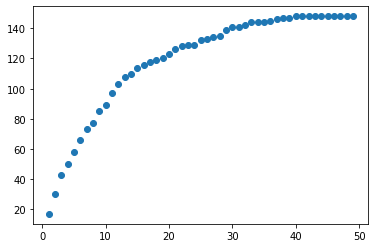

In [17]:
X = []
y = []

for n in range(1, 50):
    site_topn = dict()
    uniquespecies = []

    idx = 0
    sites_with_no_data = 0
    for site in site_codes:
        month, percCover = data[idx]

        if month is None:
            sites_with_no_data += 1
            print('--', site, 'had no data', '---')
            continue

        percCover.sort(key = lambda x: x[-1])

        topn = dict()

        for i in range(1, min(len(percCover) + 1, n + 1)):
            topn[percCover[-i][0]] = percCover[-i][1]
            if percCover[-i][0] not in uniquespecies:
                uniquespecies.append(percCover[-i][0])

        site_topn[site] = topn

        idx += 1

    X.append(n)
    y.append(len(uniquespecies))

plt.scatter(X, y)

observation: it looks like the top 10 species in each site basically covers almost all of the top species in all the sites

question: what happens when we also take into account percent cover, and not just the number of unique species?

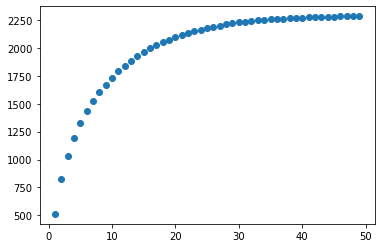

In [18]:
X = []
y = []

for n in range(1, 50):
    site_topn = dict()
    uniquespecies = []

    totalperccover = 0
    
    idx = 0
    sites_with_no_data = 0
    for site in site_codes:
        month, percCover = data[idx]

        if month is None:
            sites_with_no_data += 1
            print('--', site, 'had no data', '---')
            continue

        percCover.sort(key = lambda x: x[-1])

        topn = dict()

        for i in range(1, min(len(percCover) + 1, n + 1)):
            topn[percCover[-i][0]] = percCover[-i][1]
            totalperccover += percCover[-i][1]
            if percCover[-i][0] not in uniquespecies:
                uniquespecies.append(percCover[-i][0])

        site_topn[site] = topn

        idx += 1

    X.append(n)
    y.append(totalperccover)

plt.scatter(X, y)

with percentages for easier formatting

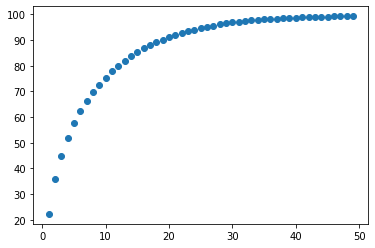

In [19]:
X = []
y = []

for n in range(1, 50):
    site_topn = dict()
    uniquespecies = []

    totalperccover = 0
    
    idx = 0
    sites_with_no_data = 0
    for site in site_codes:
        month, percCover = data[idx]

        if month is None:
            sites_with_no_data += 1
            print('--', site, 'had no data', '---')
            continue

        percCover.sort(key = lambda x: x[-1])

        topn = dict()

        for i in range(1, min(len(percCover) + 1, n + 1)):
            topn[percCover[-i][0]] = percCover[-i][1]
            totalperccover += percCover[-i][1]
            if percCover[-i][0] not in uniquespecies:
                uniquespecies.append(percCover[-i][0])

        site_topn[site] = topn

        idx += 1

    X.append(n)
    y.append(totalperccover / 2300 * 100)

plt.scatter(X, y)

it looks like the top 10 species (in each site) accounts for 80% of the plant cover (across all sites)

## summarize communities using NMDS plot

In [20]:
# generate vectors
# gen enumerated unique species list

enumspecies = []

idx = 0
sites_with_no_data = 0
for site in site_codes:
    month, percCover = data[idx]
    
    if month is None:
        sites_with_no_data += 1
        print('--', site, 'had no data', '---')
        continue
    
    for i in range(len(percCover)):
        if percCover[i][0] not in enumspecies:
            enumspecies.append(percCover[i][0])
    
    idx += 1

print('warning:', sites_with_no_data, 'sites had no data')

In [21]:
# generate vectors

X = []

idx = 0
sites_with_no_data = 0
for site in site_codes:
    month, percCover = data[idx]
    
    if month is None:
        sites_with_no_data += 1
        print('--', site, 'had no data', '---')
        continue
    
    current = []
    
    for s in enumspecies:
        done = False
        
        for p in percCover:
            a, b = p
            if a == s:
                current.append(b)
                done = True
                break
        
        if not done:
            current.append(0)
    
    X.append(current)
    
    idx += 1

print('warning:', sites_with_no_data, 'sites had no data')

In [22]:
from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA

similarities = euclidean_distances(X)

In [23]:
seed = 42

mds = manifold.MDS(
    n_components=2,
    max_iter=3000,
    eps=1e-9,
    random_state=seed,
    dissimilarity="precomputed",
    n_jobs=1,
    normalized_stress="auto",
)
pos = mds.fit(similarities).embedding_

nmds = manifold.MDS(
    n_components=2,
    metric=False,
    max_iter=3000,
    eps=1e-12,
    dissimilarity="precomputed",
    random_state=seed,
    n_jobs=1,
    n_init=1,
    normalized_stress=True,
)
npos = nmds.fit_transform(similarities, init=pos)

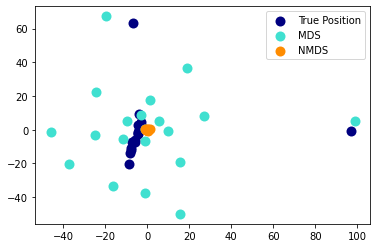

In [24]:
clf = PCA(n_components=2)
X_true = clf.fit_transform(X)

pos = clf.fit_transform(pos)

npos = clf.fit_transform(npos)

s = 100
plt.scatter(X_true[:, 0], X_true[:, 1], color="navy", s=s, lw=0, label="True Position")
plt.scatter(pos[:, 0], pos[:, 1], color="turquoise", s=s, lw=0, label="MDS")
plt.scatter(npos[:, 0], npos[:, 1], color="darkorange", s=s, lw=0, label="NMDS")
plt.legend(scatterpoints=1, loc="best", shadow=False)

0.10352397256261389


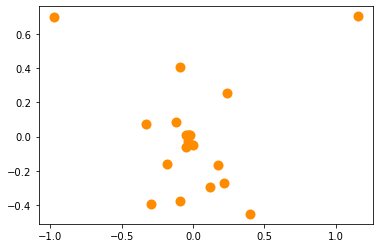

In [25]:
plt.scatter(npos[:, 0], npos[:, 1], color="darkorange", s=s, lw=0, label="NMDS")
print(nmds.stress_)

In [26]:
import numpy as np

n = len(X)

farthesttwo = ()
farthestdist = 0

for i in range(n):
    for j in range(i + 1, n):
        dist = np.linalg.norm(np.array(X[i]) - np.array(X[j]))
        
        if dist > farthestdist:
            farthestdist = dist
            farthesttwo = (i, j)

print(farthestdist)
print(site_codes[farthesttwo[0]], site_codes[farthesttwo[1]])

123.47873447103552
WOOD SRER


## get mycorrhizae type for each plant species

In [31]:
mycodb_csv = pd.read_csv('mycodb/MycoDB_version4.csv')

In [72]:
def format_species(species):
    '''species = species.lower()
    parts = species.split()
    return parts[0] + '_' + parts[1]'''

    return species.lower()

def get_myco_type(species, out=True):
    # PlantSpecies
    rows = mycodb_csv['PlantFamily'] == format_species(species)
    
    type_count = dict()
    
    for index, row in mycodb_csv[rows].iterrows():
        mtype = row['MYCORRHIZAETYPE']
        
        if mtype not in type_count:
            type_count[mtype] = 0
        
        type_count[mtype] += 1
    
    if out and len(type_count) > 1:
        print('warning: number of mycorrhizae types present at this plant species is', len(type_count), 'species:', type_count)
    
    mtype = None
    best_count = 0
    
    for key in type_count:
        if type_count[key] > best_count:
            best_count = type_count[key]
            mtype = key
    
    if out and mtype is None:
        print('Warning: no data found for this plant species:', format_species(species))
    
    return mtype

In [62]:
get_myco_type('Calopogonium Caeruleum')

In [63]:
def get_species_data_from_site(SITE_CODE):
    # plant presence and percent cover
    PRODUCTCODE = 'DP1.10058.001'
    
    url = SERVER+'sites/'+SITE_CODE
    
    #Request the url
    site_request = requests.get(url)

    #Convert the request to Python JSON object
    site_json = site_request.json()
    
    months = []

    for product in site_json['data']['dataProducts']: 
        #if a list item's 'dataProductCode' dict element equals the product code string
        if(product['dataProductCode'] == PRODUCTCODE): 
            for month in product['availableMonths']:
                months.append(month)

    months.sort()
    
    print(SITE_CODE, months)
    
    month_idx = 0
    latest_month = months[0]
    df = None
    
    # try an earlier month
    def redownload_data():    
        nonlocal df
        nonlocal month_idx
        nonlocal latest_month
        
        month_idx -= 1
        
        if month_idx < -len(months):
            df = None
            return
        
        latest_month = months[month_idx]
        latest_month = months[month_idx]
        data_request = requests.get(SERVER+'data/'+PRODUCTCODE+'/'+SITE_CODE+'/'+latest_month)
        data_json = data_request.json()

        url = None
        name = None

        for file in data_json['data']['files']:
            if '1m2' in file['name']:
                url = file['url']
                name = file['name']

        if not os.path.isfile('data/' + name):
            urllib.request.urlretrieve(url, 'data/' + name)

        df = pd.read_csv('data/' + name)
    
    redownload_data()
    
    # redownload earlier data if more than half of scientificName/percentcover data is Nan
    while True:
        if df is None:
            return (None, None)
        
        num_rows = df.shape[0]
        num_nan = max(df['scientificName'].isnull().sum(), df['percentCover'].isnull().sum())
        
        if num_nan > num_rows - 50:
            # try an earlier month
            redownload_data()
        else:
            print('month:', latest_month)
            break
    
    avg_tracker = dict()

    def isnan(val):
        return type(val) == float and math.isnan(val)

    for index, row in df.iterrows():
        if isnan(row['scientificName']) or isnan(row['percentCover']):
            continue

        scientificName = row['scientificName']
        percCover = row['percentCover']

        if scientificName not in avg_tracker:
            avg_tracker[scientificName] = (0, 0)

        avg_tracker[scientificName] = (avg_tracker[scientificName][0] + percCover, avg_tracker[scientificName][1] + 1)

    avgPercCover = []
    sumAvgPercCover = 0

    for key in avg_tracker:
        avgPercCover.append((key, avg_tracker[key][0] / avg_tracker[key][1]))
        sumAvgPercCover += avgPercCover[-1][1]

    return (latest_month, avgPercCover)

In [77]:
data_spec = []

count = 0

for site in site_codes:
    month, percCover = data[count] #get_family_data_from_site(site)
    count += 1
    
    type_cover = dict()
    
    for species, perc in percCover:
        myco_type = get_myco_type(species, out=False)
        
        if myco_type not in type_cover:
            type_cover[myco_type] = 0
        
        type_cover[myco_type] += perc
        
        #print(species, ':', myco_type)
    
    data_spec.append((site, type_cover))
    print(site, type_cover)

UNDE {None: 120.97546685340802, 'EM': 37.20833333333333, 'AM': 45.97161101862129}
WOOD {None: 152.8409523809524, 'AM': 73.6091655084405}
CPER {'AM': 17.776348651348652, None: 12.077272727272726}
NIWO {None: 18.446320346320345, 'AM': 19.71657239562037, 'EM': 42.431318681318686}
KONZ {None: 31.23651635720601, 'AM': 45.214000219900186, 'EM': 4.583333333333333}
HARV {None: 101.16924035632559, 'AM': 48.73799033296418, 'EM': 17.044999459248498}
SCBI {'AM': 40.84735772357723, None: 10.720238095238095}
OSBS {None: 14.9, 'AM': 27.691345673317187, 'EM': 14.0}
TALL {None: 137.47098631121648, 'AM': 66.9989373323915, 'EM': 17.099431297009723}
CLBJ {'AM': 57.7729685964442, None: 24.144444444444446, 'EM': 7.160714285714286}
SRER {'AM': 99.58883541814077, None: 61.48331173454143}
ONAQ {'AM': 36.0035226848601, None: 1.7004310344827587}
SJER {None: 22.810173160173157, 'AM': 49.79313039485152, 'EM': 1.25}
WREF {'AM': 59.835, None: 32.53436868686869, 'EM': 28.32572463768116}
YELL {None: 49.08114035087719,

In [80]:
hey = [1, 5, 20]

hey[:-1]

[1, 5]

In [81]:
for site, stuff in data_spec:
    stuff_list = []
    
    for key in stuff:
        stuff_list.append((stuff[key], key))
    
    stuff_list.sort()
    
    minority_sum = 0
    
    for perc, type_ in stuff_list[:-1]:
        minority_sum += perc
    
    if minority_sum < stuff_list[-1][0]:
        print(site, 'majority type is', stuff_list[-1][1])
    else:
        print(site, 'has no clear majority')

UNDE majority type is None
WOOD majority type is None
CPER majority type is AM
NIWO majority type is EM
KONZ majority type is AM
HARV majority type is None
SCBI majority type is AM
OSBS has no clear majority
TALL majority type is None
CLBJ majority type is AM
SRER majority type is AM
ONAQ majority type is AM
SJER majority type is AM
WREF has no clear majority
YELL has no clear majority
GUAN majority type is None
BONA has no clear majority
TOOL has no clear majority
PUUM majority type is None
ORNL majority type is AM
